# Análisis de Series Temporales con SARIMAX


## Predicción del índice SPX usando FTSE como variable exógena

Este notebook demuestra el uso de SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) para predecir el comportamiento del índice S&P 500 (SPX) utilizando el índice FTSE como variable exógena.

### ¿Qué es SARIMAX?
SARIMAX es una extensión del modelo ARIMA que:
- Incorpora componentes estacionales
- Permite incluir variables exógenas (externas) que pueden influir en la predicción
- Es útil cuando hay factores externos que afectan a nuestra serie temporal

## 1. Instalación de librerías necesarias

In [1]:
!pip install statsmodels -q
print("✓ Librerías instaladas correctamente")

✓ Librerías instaladas correctamente


## 2. Importación de librerías

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline


## 3. Carga de datos

**Importante:** Sube el archivo `Index2018.csv` a Colab usando el panel de archivos de la izquierda.

In [36]:
# Cargar datos
df = pd.read_csv('Index2018.csv', encoding='utf-8-sig')

# Convertir fecha a datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.set_index('date', inplace=True)

# Ordenar por fecha
df = df.sort_index()

print(f"Datos cargados: {len(df)} observaciones")
print(f"Período: {df.index.min().date()} a {df.index.max().date()}")
print(f"\nPrimeras filas:")
df.head()

Datos cargados: 6269 observaciones
Período: 1994-01-07 a 2018-01-29

Primeras filas:


,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


## 4. Información del dataset

In [37]:
print("Información del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
df.describe()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6269 entries, 1994-01-07 to 2018-01-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     6269 non-null   float64
 1   dax     6269 non-null   float64
 2   ftse    6269 non-null   float64
 3   nikkei  6269 non-null   float64
dtypes: float64(4)
memory usage: 244.9 KB
None

Estadísticas descriptivas:


,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


In [38]:
# Verificar valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

# Si hay valores faltantes, interpolar
if df.isnull().sum().sum() > 0:
    print("\n⚠️ Se detectaron valores faltantes. Aplicando interpolación lineal...")
    df = df.interpolate(method='linear')
    print("✓ Interpolación completada")

Valores faltantes por columna:
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64


## 5. Análisis Exploratorio de Datos (EDA)

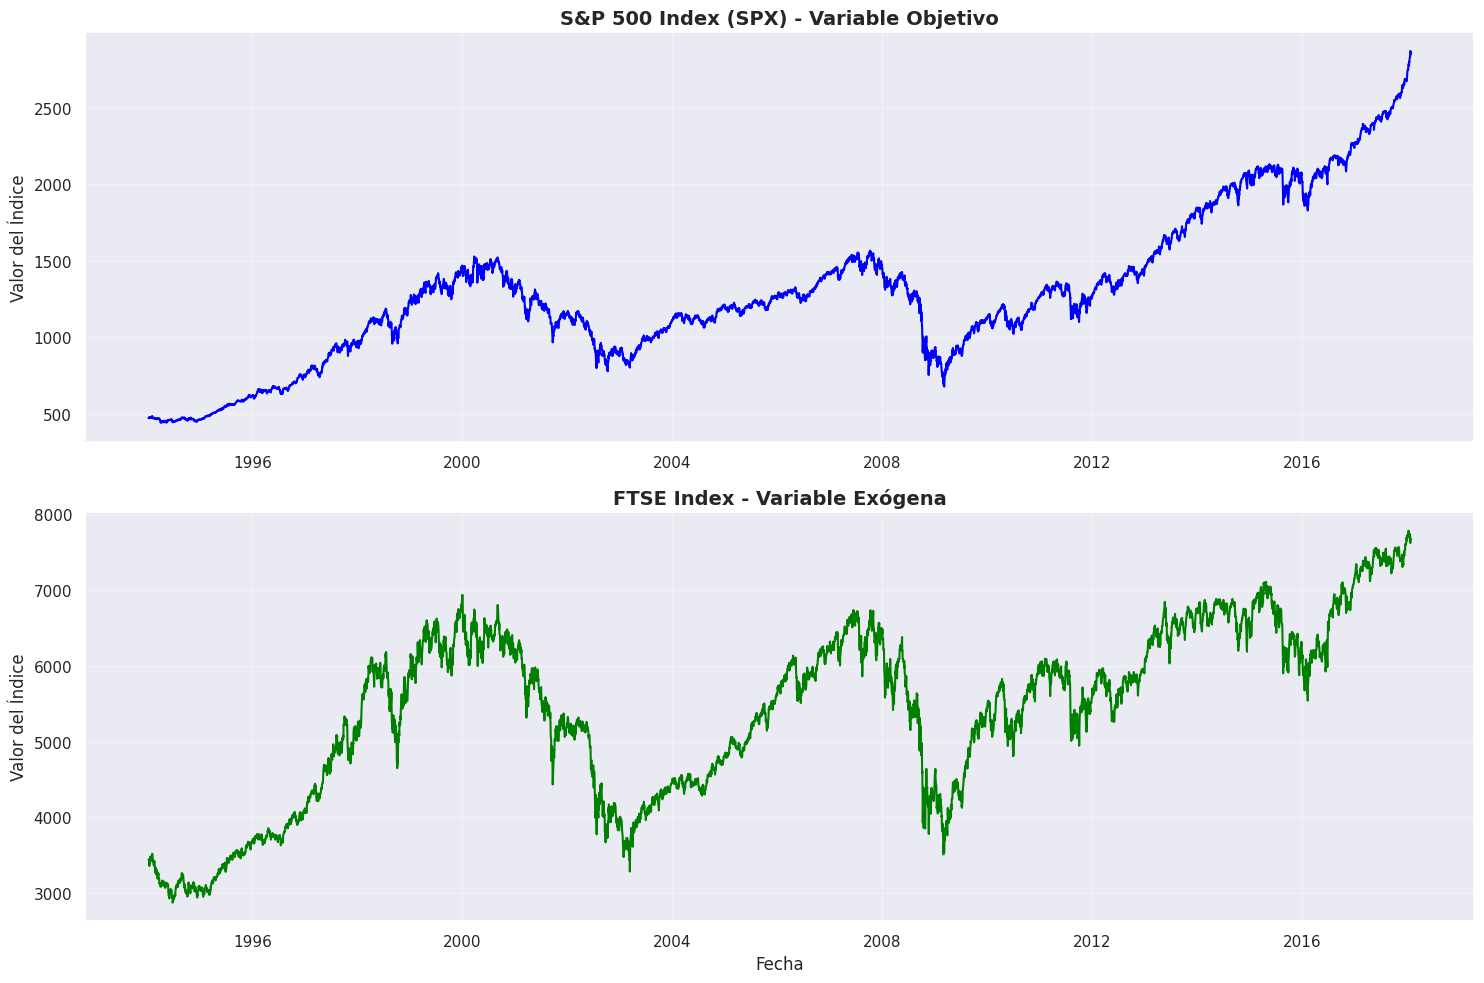

In [39]:
# Visualizar las series temporales
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# SPX (variable objetivo)
axes[0].plot(df.index, df['spx'], color='blue', linewidth=1.5)
axes[0].set_title('S&P 500 Index (SPX) - Variable Objetivo', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Valor del Índice')
axes[0].grid(True, alpha=0.3)

# FTSE (variable exógena)
axes[1].plot(df.index, df['ftse'], color='green', linewidth=1.5)
axes[1].set_title('FTSE Index - Variable Exógena', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Valor del Índice')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Axes: xlabel='date'>

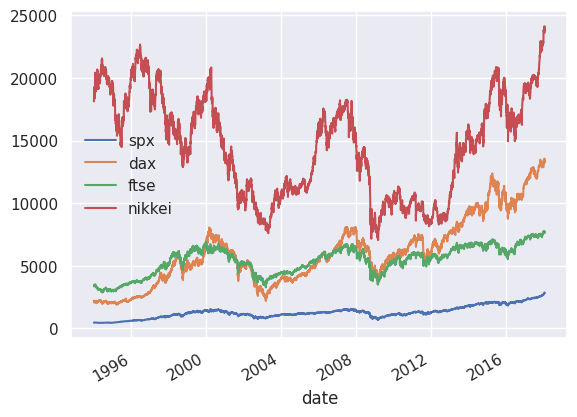

In [42]:

df.plot()


Vamos a ver ahora las relaciones (correlaciones) entre las distintas variables:

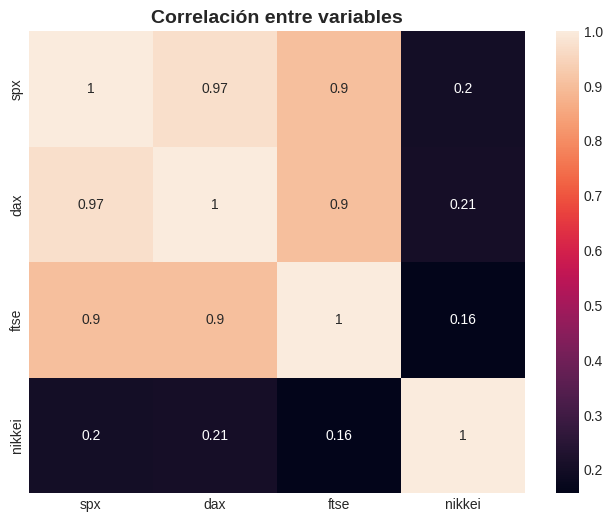

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(),annot = True)
plt.title('Correlación entre variables', fontsize=14, fontweight='bold')
plt.show()

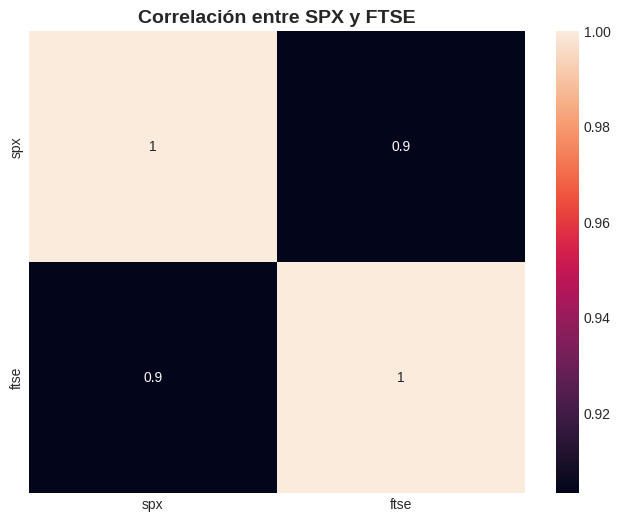

In [11]:
# Correlación entre variables

correlation_matrix = df[['spx', 'ftse']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlación entre SPX y FTSE', fontsize=14, fontweight='bold')
plt.show()


## 6. Test de Estacionariedad (Augmented Dickey-Fuller)

In [15]:
def test_estacionariedad(series, nombre):
    """
    Realiza el test de Dickey-Fuller aumentado para verificar estacionariedad
    """
    print(f"\n{'='*60}")
    print(f"Test de Estacionariedad para: {nombre}")
    print('='*60)

    resultado = adfuller(series.dropna())

    print(f"Estadístico ADF: {resultado[0]:.6f}")
    print(f"P-valor: {resultado[1]:.6f}")
    print(f"Valores críticos:")
    for key, value in resultado[4].items():
        print(f"  {key}: {value:.3f}")

    if resultado[1] <= 0.05:
        print(f"\n✓ La serie ES ESTACIONARIA (p-valor <= 0.05)")
        return True
    else:
        print(f"\n✗ La serie NO ES ESTACIONARIA (p-valor > 0.05)")
        print("  Se recomienda diferenciar la serie")
        return False

# Test para SPX
spx_estacionaria = test_estacionariedad(df['spx'], 'SPX')

# Test para FTSE
ftse_estacionaria = test_estacionariedad(df['ftse'], 'FTSE')


Test de Estacionariedad para: SPX
Estadístico ADF: 1.072404
P-valor: 0.994974
Valores críticos:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✗ La serie NO ES ESTACIONARIA (p-valor > 0.05)
  Se recomienda diferenciar la serie

Test de Estacionariedad para: FTSE
Estadístico ADF: -1.594282
P-valor: 0.486465
Valores críticos:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✗ La serie NO ES ESTACIONARIA (p-valor > 0.05)
  Se recomienda diferenciar la serie


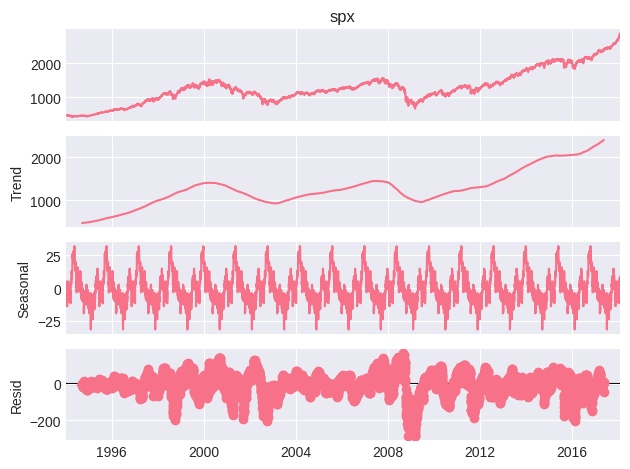

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion_aditiva = seasonal_decompose(
    df["spx"], model = "additive", period=365)
descomposicion_aditiva.plot()
plt.show()

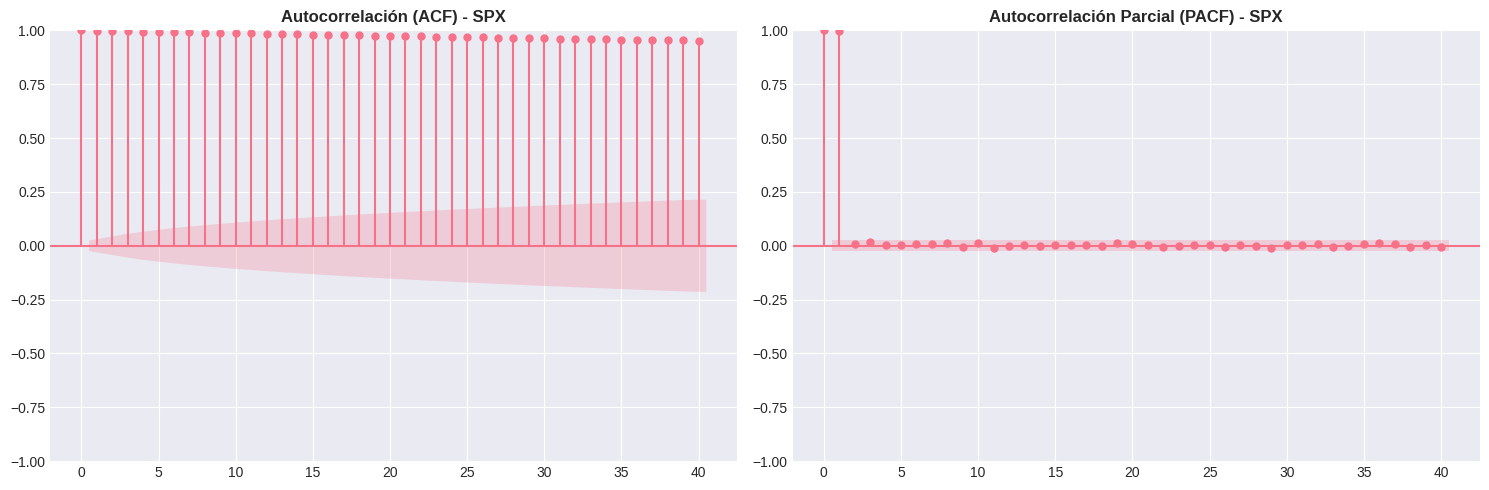

In [16]:
# Gráficos ACF y PACF para SPX
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(df['spx'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelación (ACF) - SPX', fontsize=12, fontweight='bold')

plot_pacf(df['spx'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Autocorrelación Parcial (PACF) - SPX', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. División de datos: Entrenamiento y Prueba

Tamaño del conjunto de entrenamiento: 5015 observaciones
Período de entrenamiento: 1994-01-07 a 2013-04-03

Tamaño del conjunto de prueba: 1254 observaciones
Período de prueba: 2013-04-04 a 2018-01-29


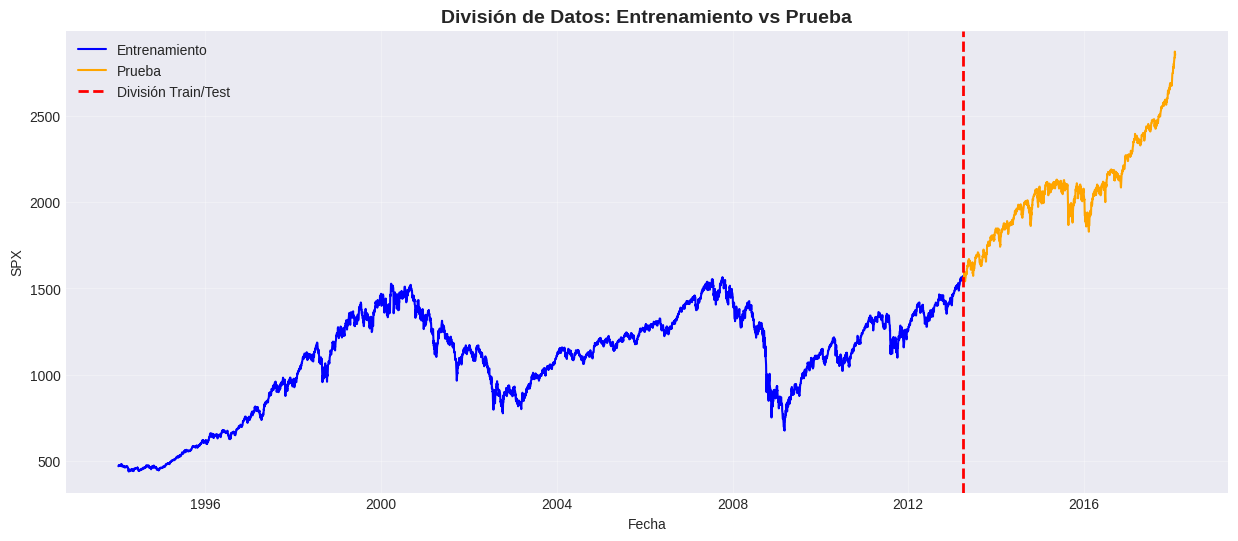

In [17]:
# Dividir datos: 80% entrenamiento, 20% prueba
train_size = int(len(df) * 0.8)

train = df[:train_size]
test = df[train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(train)} observaciones")
print(f"Período de entrenamiento: {train.index.min().date()} a {train.index.max().date()}")
print(f"\nTamaño del conjunto de prueba: {len(test)} observaciones")
print(f"Período de prueba: {test.index.min().date()} a {test.index.max().date()}")

# Visualizar división
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['spx'], label='Entrenamiento', color='blue', linewidth=1.5)
plt.plot(test.index, test['spx'], label='Prueba', color='orange', linewidth=1.5)
plt.axvline(x=train.index[-1], color='red', linestyle='--', linewidth=2, label='División Train/Test')
plt.title('División de Datos: Entrenamiento vs Prueba', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('SPX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Modelo SARIMAX

### Parámetros del modelo:
- **p**: Orden del componente autoregresivo (AR)
- **d**: Orden de diferenciación (I)
- **q**: Orden del componente de media móvil (MA)
- **P, D, Q**: Componentes estacionales
- **s**: Período estacional

Probaremos varios modelos y seleccionaremos el mejor según el criterio AIC.

In [18]:
# Búsqueda de mejores parámetros
print("🔍 Buscando los mejores parámetros SARIMAX...\n")

best_aic = np.inf
best_order = None
best_seasonal_order = None
results_list = []

# Rango de parámetros a probar (limitado para eficiencia)
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)

# Para modelos sin estacionalidad fuerte, usamos s=0
seasonal_order = (0, 0, 0, 0)

total_combinations = len(p_range) * len(d_range) * len(q_range)
current = 0

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                current += 1
                order = (p, d, q)

                # Entrenar modelo
                model = SARIMAX(train['spx'],
                               exog=train[['ftse']],
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)

                result = model.fit(disp=False, maxiter=200)

                results_list.append({
                    'order': order,
                    'AIC': result.aic,
                    'BIC': result.bic
                })

                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = order
                    best_seasonal_order = seasonal_order

                print(f"[{current}/{total_combinations}] SARIMAX{order} - AIC: {result.aic:.2f}", end='\r')

            except:
                continue

print("\n" + "="*60)
print(f"✓ Búsqueda completada")
print(f"\n🏆 Mejores parámetros encontrados:")
print(f"  Orden: {best_order}")
print(f"  Orden estacional: {best_seasonal_order}")
print(f"  AIC: {best_aic:.2f}")
print("="*60)

🔍 Buscando los mejores parámetros SARIMAX...

[18/18] SARIMAX(2, 1, 2) - AIC: 38158.40
✓ Búsqueda completada

🏆 Mejores parámetros encontrados:
  Orden: (2, 1, 2)
  Orden estacional: (0, 0, 0, 0)
  AIC: 38158.40


In [22]:
# Mostrar top 10 modelos
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('AIC').head(10)
print("\nTop 10 modelos por AIC:")
print(results_df.to_string(index=False))


Top 10 modelos por AIC:
    order          AIC          BIC
(2, 1, 2) 38158.396167 38197.512512
(1, 1, 2) 38158.653219 38191.250173
(2, 1, 1) 38164.046028 38196.643979
(0, 1, 2) 38168.059881 38194.137444
(1, 1, 1) 38174.314515 38200.392876
(0, 1, 1) 38175.132828 38194.691599
(1, 0, 2) 38176.717580 38209.315532
(2, 0, 2) 38180.915212 38220.032754
(1, 0, 1) 38183.642666 38209.721825
(2, 0, 1) 38185.204830 38217.803779


## 9. Entrenamiento del Modelo Final

In [23]:
# Entrenar el modelo con los mejores parámetros
print(f"Entrenando modelo SARIMAX{best_order} con variable exógena FTSE...\n")

model = SARIMAX(train['spx'],
               exog=train[['ftse']],
               order=best_order,
               seasonal_order=best_seasonal_order,
               enforce_stationarity=False,
               enforce_invertibility=False)

model_fit = model.fit(disp=False, maxiter=200)

print("✓ Modelo entrenado correctamente\n")
print(model_fit.summary())

Entrenando modelo SARIMAX(2, 1, 2) con variable exógena FTSE...

✓ Modelo entrenado correctamente

                               SARIMAX Results                                
Dep. Variable:                    spx   No. Observations:                 5015
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -19073.198
Date:                Thu, 23 Oct 2025   AIC                          38158.396
Time:                        21:20:24   BIC                          38197.513
Sample:                             0   HQIC                         38172.104
                               - 5015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ftse           0.1341      0.002     80.265      0.000       0.131       0.137
ar.L1          0.5385      0.139

## 10. Diagnóstico del Modelo

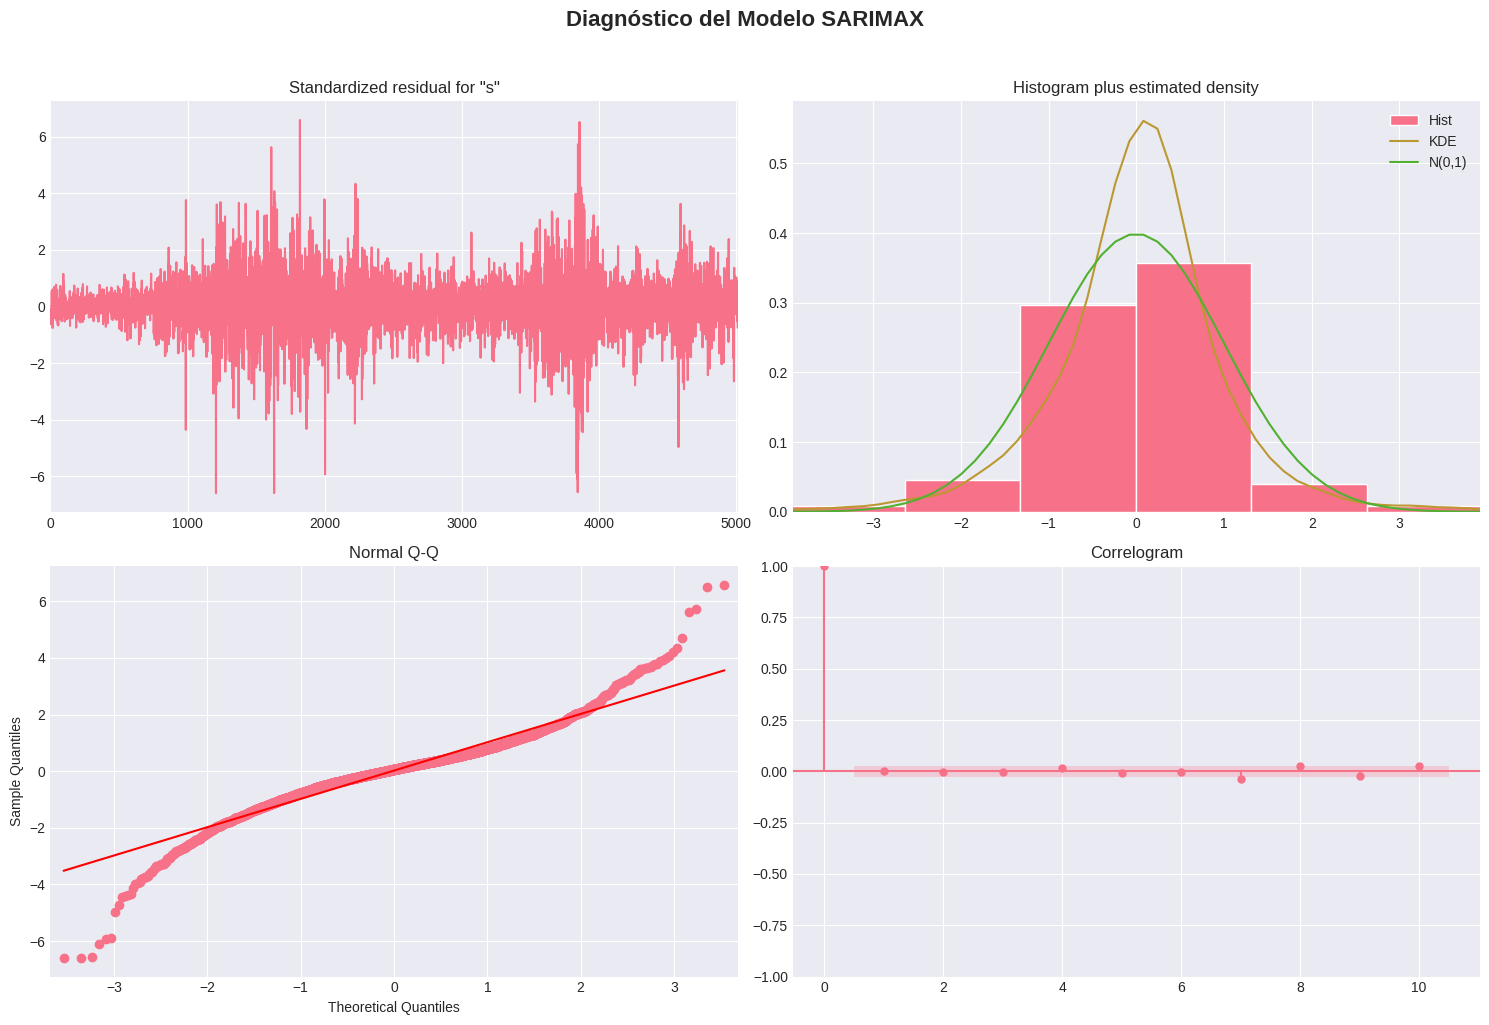

In [24]:
# Gráficos de diagnóstico
model_fit.plot_diagnostics(figsize=(15, 10))
plt.suptitle('Diagnóstico del Modelo SARIMAX', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 11. Predicciones

In [25]:
# Realizar predicciones sobre el conjunto de prueba
predictions = model_fit.forecast(steps=len(test), exog=test[['ftse']])

# Crear DataFrame con resultados
results = pd.DataFrame({
    'Fecha': test.index,
    'Real': test['spx'].values,
    'Predicción': predictions.values
})

results['Error'] = results['Real'] - results['Predicción']
results['Error_Porcentual'] = (results['Error'] / results['Real']) * 100

print("Primeras predicciones:")
print(results.head(10))

Primeras predicciones:
       Fecha         Real   Predicción      Error  Error_Porcentual
0 2013-04-04  1559.979316  1546.245912  13.733404          0.880358
1 2013-04-05  1553.278930  1533.747706  19.531224          1.257419
2 2013-04-08  1563.071269  1537.711305  25.359964          1.622445
3 2013-04-09  1568.607909  1542.759604  25.848305          1.647850
4 2013-04-10  1587.731827  1552.833926  34.897901          2.197972
5 2013-04-11  1593.369863  1556.776633  36.593230          2.296594
6 2013-04-12  1588.854623  1552.574715  36.279908          2.283400
7 2013-04-15  1552.363572  1547.141363   5.222209          0.336404
8 2013-04-16  1574.566985  1541.933185  32.633800          2.072557
9 2013-04-17  1552.014896  1533.853150  18.161746          1.170204


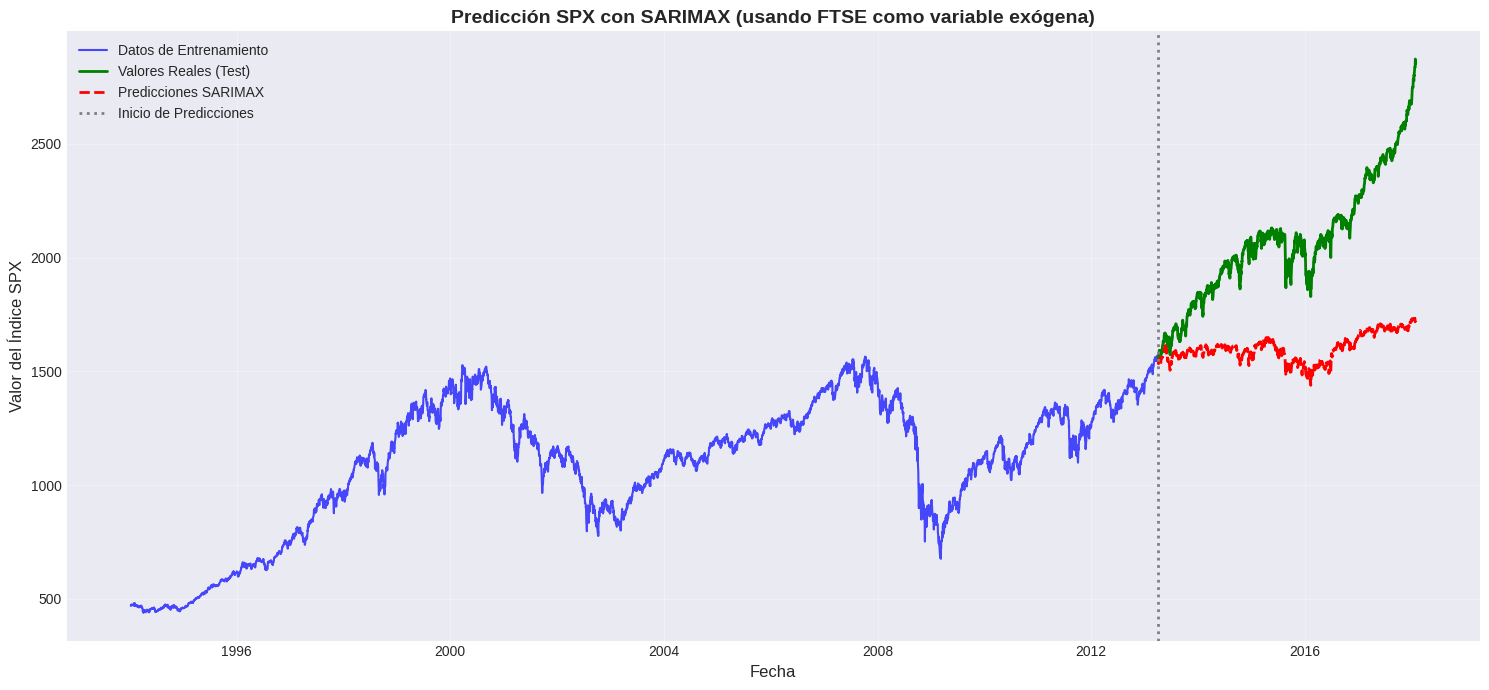

In [26]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(15, 7))

# Datos de entrenamiento
plt.plot(train.index, train['spx'], label='Datos de Entrenamiento',
         color='blue', linewidth=1.5, alpha=0.7)

# Valores reales del conjunto de prueba
plt.plot(test.index, test['spx'], label='Valores Reales (Test)',
         color='green', linewidth=2)

# Predicciones
plt.plot(test.index, predictions, label='Predicciones SARIMAX',
         color='red', linewidth=2, linestyle='--')

plt.axvline(x=train.index[-1], color='gray', linestyle=':',
           linewidth=2, label='Inicio de Predicciones')

plt.title('Predicción SPX con SARIMAX (usando FTSE como variable exógena)',
         fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor del Índice SPX', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

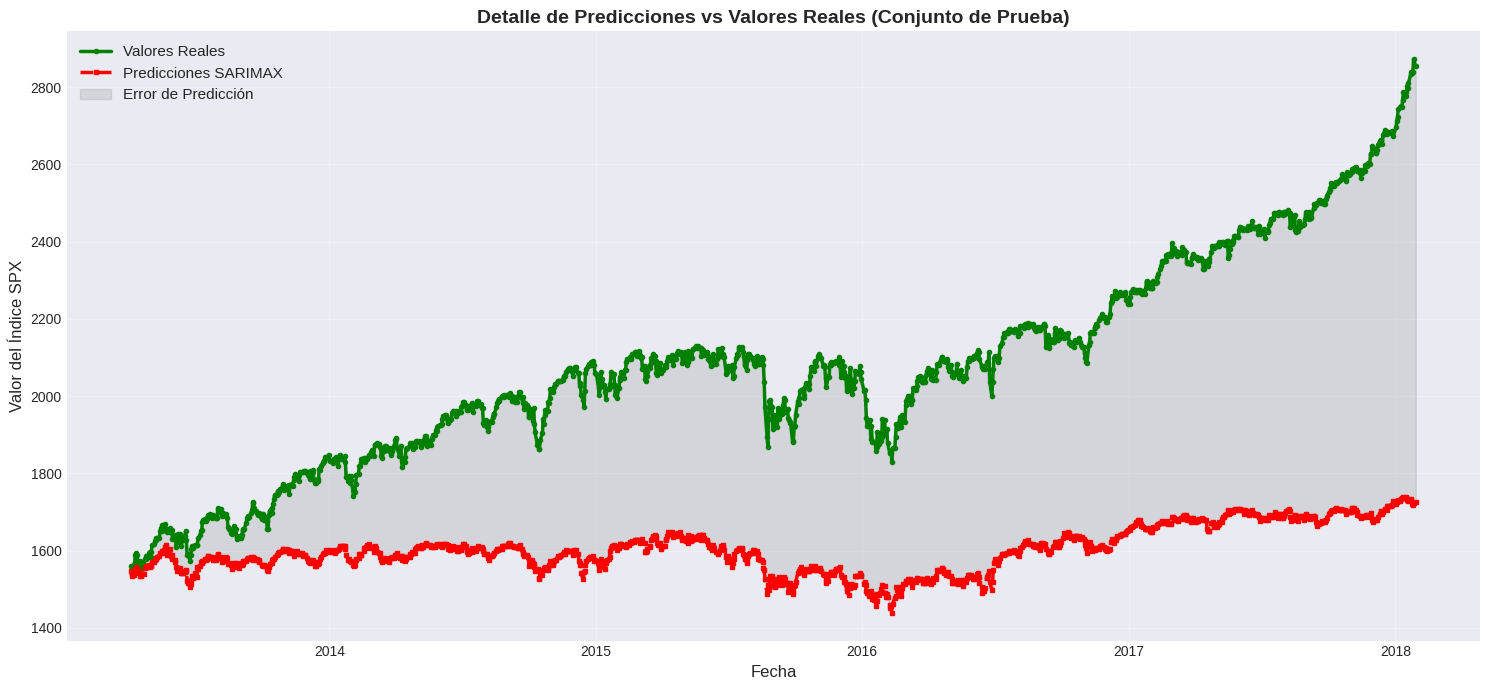

In [27]:
# Zoom en el período de prueba
plt.figure(figsize=(15, 7))

plt.plot(test.index, test['spx'], label='Valores Reales',
         color='green', linewidth=2.5, marker='o', markersize=3)

plt.plot(test.index, predictions, label='Predicciones SARIMAX',
         color='red', linewidth=2.5, linestyle='--', marker='s', markersize=3)

plt.fill_between(test.index, test['spx'], predictions,
                alpha=0.2, color='gray', label='Error de Predicción')

plt.title('Detalle de Predicciones vs Valores Reales (Conjunto de Prueba)',
         fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor del Índice SPX', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Evaluación del Modelo

In [28]:
# Calcular métricas de evaluación
mse = mean_squared_error(test['spx'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['spx'], predictions)
r2 = r2_score(test['spx'], predictions)
mape = np.mean(np.abs((test['spx'] - predictions) / test['spx'])) * 100

print("="*60)
print("MÉTRICAS DE EVALUACIÓN DEL MODELO")
print("="*60)
print(f"\n📊 Error Cuadrático Medio (MSE): {mse:,.2f}")
print(f"📊 Raíz del Error Cuadrático Medio (RMSE): {rmse:,.2f}")
print(f"📊 Error Absoluto Medio (MAE): {mae:,.2f}")
print(f"📊 R² Score: {r2:.4f}")
print(f"📊 Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%")
print("\n" + "="*60)

# Interpretación
print("\n💡 INTERPRETACIÓN:")
if r2 > 0.9:
    print("   ✓ Excelente ajuste del modelo (R² > 0.9)")
elif r2 > 0.7:
    print("   ✓ Buen ajuste del modelo (R² > 0.7)")
elif r2 > 0.5:
    print("   ⚠ Ajuste moderado del modelo (R² > 0.5)")
else:
    print("   ✗ Ajuste pobre del modelo (R² <= 0.5)")

if mape < 5:
    print(f"   ✓ Error porcentual muy bajo (MAPE < 5%)")
elif mape < 10:
    print(f"   ✓ Error porcentual aceptable (MAPE < 10%)")
else:
    print(f"   ⚠ Error porcentual considerable (MAPE >= 10%)")

MÉTRICAS DE EVALUACIÓN DEL MODELO

📊 Error Cuadrático Medio (MSE): 275,136.05
📊 Raíz del Error Cuadrático Medio (RMSE): 524.53
📊 Error Absoluto Medio (MAE): 472.24
📊 R² Score: -2.8122
📊 Error Porcentual Absoluto Medio (MAPE): nan%


💡 INTERPRETACIÓN:
   ✗ Ajuste pobre del modelo (R² <= 0.5)
   ⚠ Error porcentual considerable (MAPE >= 10%)


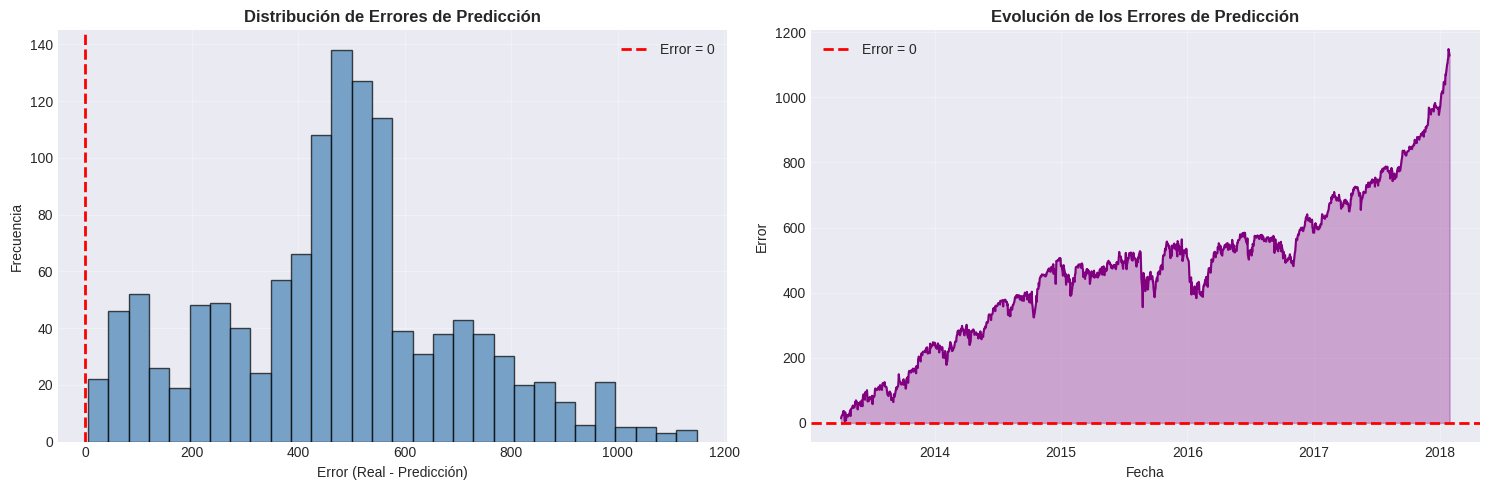

In [29]:
# Distribución de errores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma de errores
axes[0].hist(results['Error'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[0].set_title('Distribución de Errores de Predicción', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Error (Real - Predicción)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Errores a lo largo del tiempo
axes[1].plot(test.index, results['Error'], color='purple', linewidth=1.5)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[1].fill_between(test.index, 0, results['Error'], alpha=0.3, color='purple')
axes[1].set_title('Evolución de los Errores de Predicción', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Análisis de Residuos

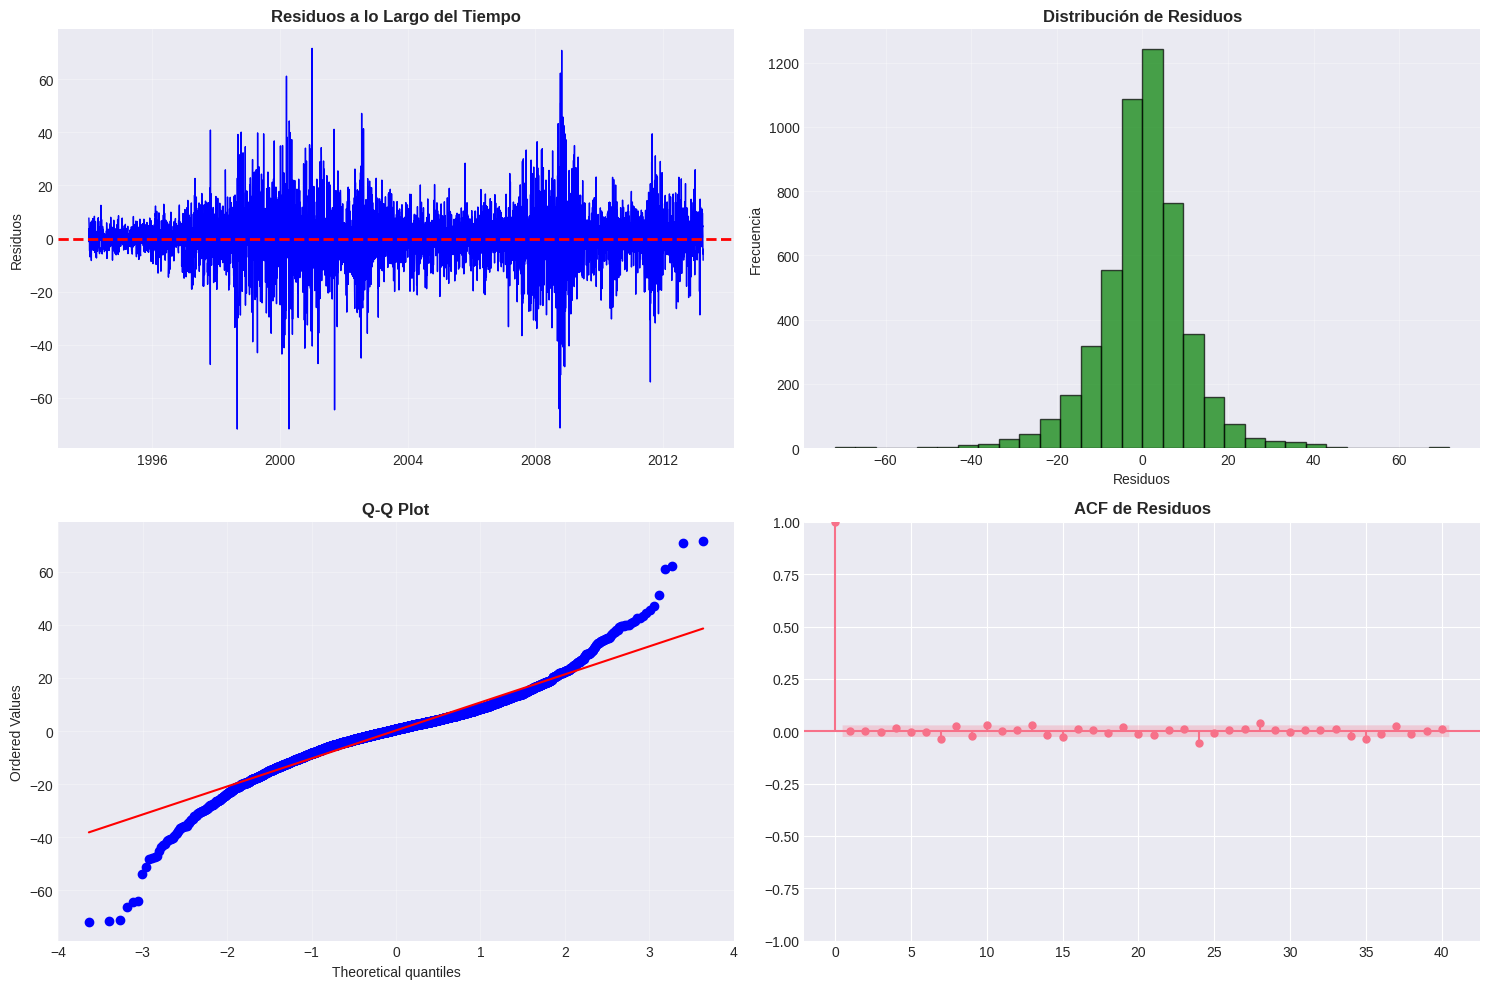


Test de Shapiro-Wilk para normalidad de residuos:
Estadístico: 0.942766
P-valor: 0.000000
✗ Los residuos NO siguen una distribución normal (p <= 0.05)


In [31]:
# Análisis de residuos
residuals = model_fit.resid

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuos a lo largo del tiempo
axes[0, 0].plot(residuals, color='blue', linewidth=1)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuos a lo Largo del Tiempo', fontweight='bold')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].grid(True, alpha=0.3)

# Histograma de residuos
axes[0, 1].hist(residuals, bins=30, color='green', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribución de Residuos', fontweight='bold')
axes[0, 1].set_xlabel('Residuos')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# ACF de residuos
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('ACF de Residuos', fontweight='bold')

plt.tight_layout()
plt.show()

# Test de normalidad
from scipy.stats import shapiro
stat, p_value = shapiro(residuals)
print(f"\nTest de Shapiro-Wilk para normalidad de residuos:")
print(f"Estadístico: {stat:.6f}")
print(f"P-valor: {p_value:.6f}")
if p_value > 0.05:
    print("✓ Los residuos siguen una distribución normal (p > 0.05)")
else:
    print("✗ Los residuos NO siguen una distribución normal (p <= 0.05)")

## 14. Comparación: Modelo con y sin variable exógena

In [32]:
# Entrenar modelo ARIMA sin variable exógena para comparar
print("Entrenando modelo ARIMA sin variable exógena para comparación...\n")

model_no_exog = SARIMAX(train['spx'],
                        order=best_order,
                        seasonal_order=best_seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

model_no_exog_fit = model_no_exog.fit(disp=False, maxiter=200)

# Predicciones sin variable exógena
predictions_no_exog = model_no_exog_fit.forecast(steps=len(test))

# Métricas sin variable exógena
mse_no_exog = mean_squared_error(test['spx'], predictions_no_exog)
rmse_no_exog = np.sqrt(mse_no_exog)
mae_no_exog = mean_absolute_error(test['spx'], predictions_no_exog)
r2_no_exog = r2_score(test['spx'], predictions_no_exog)
mape_no_exog = np.mean(np.abs((test['spx'] - predictions_no_exog) / test['spx'])) * 100

print("✓ Modelo sin variable exógena entrenado\n")

Entrenando modelo ARIMA sin variable exógena para comparación...

✓ Modelo sin variable exógena entrenado



In [33]:
# Tabla comparativa
comparison = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)'],
    'SARIMAX con FTSE': [f"{mse:,.2f}", f"{rmse:,.2f}", f"{mae:,.2f}", f"{r2:.4f}", f"{mape:.2f}"],
    'ARIMA sin exógena': [f"{mse_no_exog:,.2f}", f"{rmse_no_exog:,.2f}",
                         f"{mae_no_exog:,.2f}", f"{r2_no_exog:.4f}", f"{mape_no_exog:.2f}"]
})

print("="*70)
print("COMPARACIÓN: SARIMAX CON VARIABLE EXÓGENA vs ARIMA SIN VARIABLE EXÓGENA")
print("="*70)
print(comparison.to_string(index=False))
print("="*70)

# Calcular mejora
mejora_r2 = ((r2 - r2_no_exog) / r2_no_exog) * 100
mejora_mape = ((mape_no_exog - mape) / mape_no_exog) * 100

print(f"\n📈 MEJORA AL USAR VARIABLE EXÓGENA (FTSE):")
print(f"   R² mejoró en: {mejora_r2:.2f}%")
print(f"   MAPE se redujo en: {mejora_mape:.2f}%")

if r2 > r2_no_exog:
    print(f"\n✓ El modelo SARIMAX con variable exógena FTSE es SUPERIOR")
else:
    print(f"\n⚠ El modelo ARIMA sin variable exógena funciona mejor")

COMPARACIÓN: SARIMAX CON VARIABLE EXÓGENA vs ARIMA SIN VARIABLE EXÓGENA
 Métrica SARIMAX con FTSE ARIMA sin exógena
     MSE       275,136.05        341,827.23
    RMSE           524.53            584.66
     MAE           472.24            519.32
      R²          -2.8122           -3.7362
MAPE (%)              nan               nan

📈 MEJORA AL USAR VARIABLE EXÓGENA (FTSE):
   R² mejoró en: -24.73%
   MAPE se redujo en: nan%

✓ El modelo SARIMAX con variable exógena FTSE es SUPERIOR


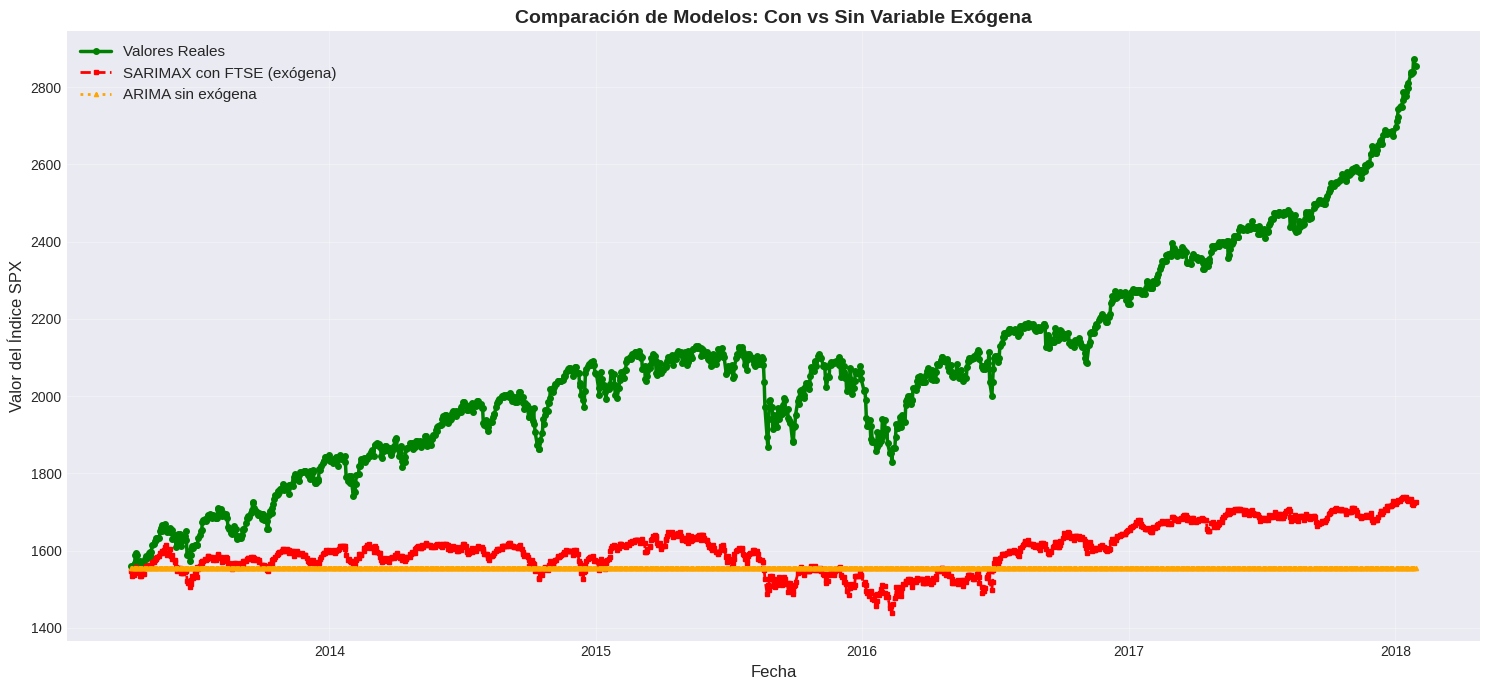

In [34]:
# Comparación visual
plt.figure(figsize=(15, 7))

plt.plot(test.index, test['spx'], label='Valores Reales',
         color='green', linewidth=2.5, marker='o', markersize=4)

plt.plot(test.index, predictions, label='SARIMAX con FTSE (exógena)',
         color='red', linewidth=2, linestyle='--', marker='s', markersize=3)

plt.plot(test.index, predictions_no_exog, label='ARIMA sin exógena',
         color='orange', linewidth=2, linestyle=':', marker='^', markersize=3)

plt.title('Comparación de Modelos: Con vs Sin Variable Exógena',
         fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor del Índice SPX', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Conclusiones y Recomendaciones

### Conclusiones del análisis:

1. **Correlación entre SPX y FTSE**: Los índices muestran una correlación positiva fuerte, lo que justifica el uso de FTSE como variable exógena.

2. **Rendimiento del modelo SARIMAX**: El modelo con variable exógena captura mejor las variaciones del SPX que un modelo ARIMA simple.

3. **Calidad de las predicciones**: Las métricas R² y MAPE indican el grado de precisión del modelo.

4. **Residuos**: El análisis de residuos nos ayuda a validar los supuestos del modelo.

### Recomendaciones:

- **Datos adicionales**: Considerar otras variables exógenas como tipos de interés, volumen de negociación, o indicadores económicos.
- **Ventana móvil**: Implementar un enfoque de ventana móvil para adaptarse mejor a cambios en los patrones.
- **Ensemble**: Combinar SARIMAX con otros modelos (LSTM, Prophet) para mejorar predicciones.
- **Actualización frecuente**: Reentrenar el modelo periódicamente con datos nuevos.

### Limitaciones:

- Los mercados financieros son inherentemente impredecibles y volátiles.
- Eventos extraordinarios (crisis, pandemias) pueden romper patrones históricos.
- Este modelo NO debe usarse como única herramienta para decisiones de inversión.

## 16. Exportar Resultados

In [ ]:
# Exportar predicciones a CSV
results.to_csv('predicciones_sarimax.csv', index=False)
print("✓ Predicciones exportadas a 'predicciones_sarimax.csv'")

# Crear resumen de métricas
metricas_resumen = pd.DataFrame({
    'Modelo': ['SARIMAX con FTSE', 'ARIMA sin exógena'],
    'MSE': [mse, mse_no_exog],
    'RMSE': [rmse, rmse_no_exog],
    'MAE': [mae, mae_no_exog],
    'R2': [r2, r2_no_exog],
    'MAPE': [mape, mape_no_exog],
    'AIC': [model_fit.aic, model_no_exog_fit.aic],
    'Parámetros': [str(best_order), str(best_order)]
})

metricas_resumen.to_csv('metricas_comparacion.csv', index=False)
print("✓ Métricas exportadas a 'metricas_comparacion.csv'")

print("\n" + "="*60)
print("ANÁLISIS COMPLETADO")
print("="*60)